In [1]:
from tensorflow import keras
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_path=r'C:\Users\naman\Downloads\archive (3)\samples'

In [3]:
def t_img (img) :
    return cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 0)

def c_img (img) :
    return cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((5,2), np.uint8))

def d_img (img) :
    return cv.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

def b_img (img) :
    return cv.GaussianBlur(img, (1,1), 0)

In [4]:
import os
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator

In [5]:
X = []
y = []

for image in os.listdir(image_path) :
    
    if image[6:] != 'png' :
        continue
    
    img = cv.imread(os.path.join(image_path, image), cv.IMREAD_GRAYSCALE)
    
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    for i in range(5) :
        X.append(img_to_array(Image.fromarray(image_list[i])))
        y.append(image[i])
X = np.array(X)
y = np.array(y)

In [6]:
X /= 255.0

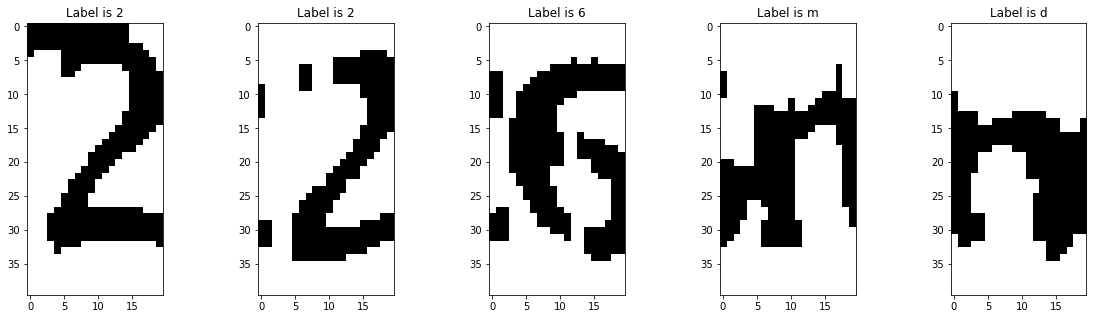

In [7]:
plt.figure(figsize = (20,5))
for i in range(5) :
    plt.subplot(1,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.title('Label is ' + str(y[i]))

In [8]:
temp = set(y)
for t in temp :
    print('Occurance count of ' + t + ' : ' + str(len(y[y == t])))

Occurance count of x : 264
Occurance count of c : 262
Occurance count of 5 : 281
Occurance count of m : 275
Occurance count of p : 253
Occurance count of e : 235
Occurance count of d : 259
Occurance count of g : 271
Occurance count of w : 235
Occurance count of b : 240
Occurance count of 6 : 259
Occurance count of 2 : 265
Occurance count of 8 : 264
Occurance count of f : 271
Occurance count of 7 : 258
Occurance count of y : 232
Occurance count of n : 525
Occurance count of 4 : 284
Occurance count of 3 : 267


In [9]:
temp_df = pd.DataFrame({'labels' : [t for t in temp], 'Count' : [len(y[y==t]) for t in temp]})

Text(0.5, 1.0, 'Label distribution in CAPTCHAS')

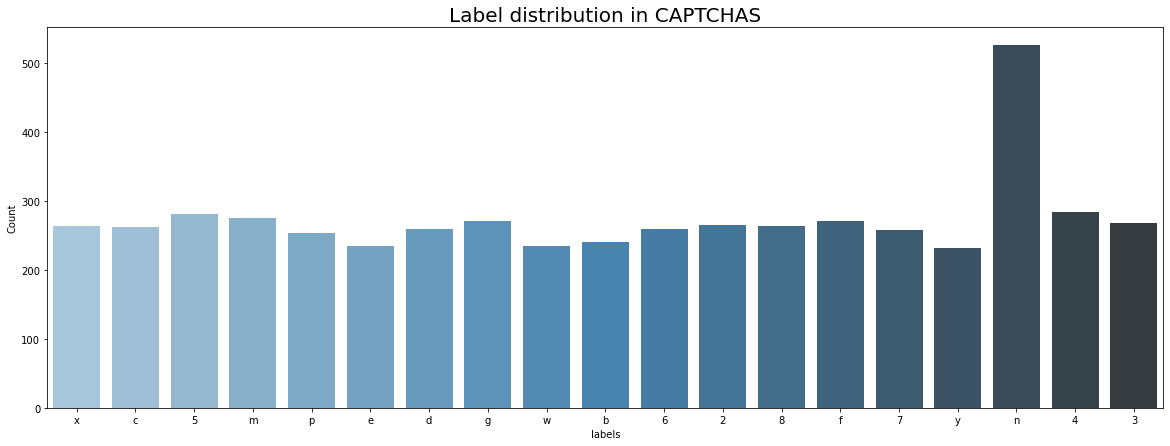

In [10]:
plt.figure(figsize = (20,7))
sns.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
plt.title('Label distribution in CAPTCHAS', fontsize = 20)

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [12]:
info = {y_combine[i] : y[i] for i in range(len(y))}

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 1)

In [14]:
y_temp = np.argmax(y_test, axis = 1)

In [15]:
temp = set(y_temp)
temp_df = pd.DataFrame({'labels' : [info[t] for t in temp], 'Count' : [len(y_temp[y_temp == t]) for t in temp]})

In [16]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input

In [17]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    
    return model
def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model


In [18]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    model.add(Input((40, 20, 1,)))
    
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    
    model.add(Dense(19, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [19]:
X_train = np.reshape(X_train, (4160, 40*20*1))

In [20]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1).fit_resample(X_train, y_train)

In [23]:
print(X_train.shape)
print(y_train.shape)

(8037, 800)
(8037, 19)


In [24]:
X_train = np.reshape(X_train, (8037, 40, 20, 1))

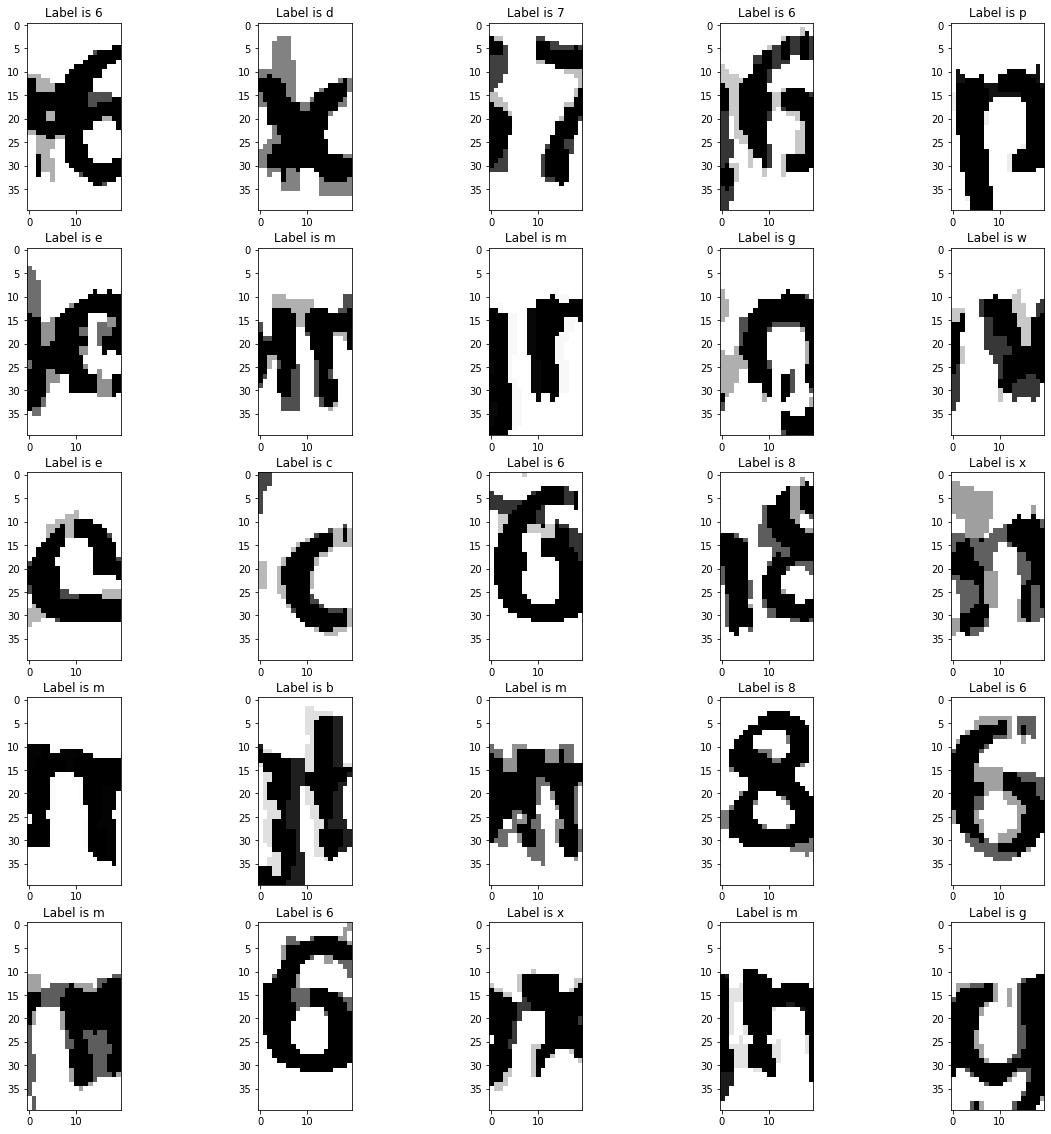

In [25]:
plt.figure(figsize = (20,20))

hi = 7800
lo = 5000

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(X_train[x], 'gray')
    plt.title('Label is ' + str(info[np.argmax(y_train[x])]))

In [26]:
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)

In [27]:
train_set = traingen.flow(X_train, y_train)

In [28]:
trainX, trainy = train_set.next()

In [29]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 20, 10, 128)       1792      
_________________________________________________________________
sequential_2 (Sequential)    (None, 10, 5, 32)         37024     
_________________________________________________________________
sequential_3 (Sequential)    (None, 5, 3, 16)          4688      
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                7840      
_________________________________________________________________
sequential_5 (Sequential)    (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 19)                6

In [30]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('./result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1)
print(X_train.shape)
print(y_train.shape)

(8037, 40, 20, 1)
(8037, 19)


In [31]:
history = model.fit(traingen.flow(X_train, y_train, batch_size = 32), validation_data = (X_test, y_test), epochs = 150, steps_per_epoch = len(X_train)/32, callbacks = [checkp])

Epoch 1/150
251/251 [==============================] - 28s 107ms/step - loss: 2.3943 - accuracy: 0.3027 - val_loss: 2.7588 - val_accuracy: 0.1962

Epoch 00001: val_loss improved from inf to 2.75882, saving model to .\result_model.h5
Epoch 2/150
251/251 [==============================] - 27s 107ms/step - loss: 1.3059 - accuracy: 0.6384 - val_loss: 1.2342 - val_accuracy: 0.6865

Epoch 00002: val_loss improved from 2.75882 to 1.23422, saving model to .\result_model.h5
Epoch 3/150
251/251 [==============================] - 25s 99ms/step - loss: 0.9595 - accuracy: 0.7322 - val_loss: 0.7611 - val_accuracy: 0.7817

Epoch 00003: val_loss improved from 1.23422 to 0.76111, saving model to .\result_model.h5
Epoch 4/150
251/251 [==============================] - 26s 104ms/step - loss: 0.7867 - accuracy: 0.7796 - val_loss: 0.6766 - val_accuracy: 0.8038

Epoch 00004: val_loss improved from 0.76111 to 0.67663, saving model to .\result_model.h5
Epoch 5/150
251/251 [==============================] - 25


Epoch 00039: val_loss did not improve from 0.39450
Epoch 40/150
251/251 [==============================] - 29s 114ms/step - loss: 0.3335 - accuracy: 0.8962 - val_loss: 0.5378 - val_accuracy: 0.8452

Epoch 00040: val_loss did not improve from 0.39450
Epoch 41/150
251/251 [==============================] - 26s 105ms/step - loss: 0.3451 - accuracy: 0.8927 - val_loss: 0.4335 - val_accuracy: 0.8837

Epoch 00041: val_loss did not improve from 0.39450
Epoch 42/150
251/251 [==============================] - 26s 104ms/step - loss: 0.3444 - accuracy: 0.8929 - val_loss: 0.5038 - val_accuracy: 0.8644

Epoch 00042: val_loss did not improve from 0.39450
Epoch 43/150
251/251 [==============================] - 26s 102ms/step - loss: 0.3293 - accuracy: 0.8964 - val_loss: 0.4350 - val_accuracy: 0.8779

Epoch 00043: val_loss did not improve from 0.39450
Epoch 44/150
251/251 [==============================] - 26s 102ms/step - loss: 0.3238 - accuracy: 0.8976 - val_loss: 0.7049 - val_accuracy: 0.8010

Epoc

251/251 [==============================] - 24s 95ms/step - loss: 0.2602 - accuracy: 0.9209 - val_loss: 0.4832 - val_accuracy: 0.8740

Epoch 00081: val_loss did not improve from 0.39450
Epoch 82/150
251/251 [==============================] - 24s 96ms/step - loss: 0.2793 - accuracy: 0.9134 - val_loss: 0.4465 - val_accuracy: 0.8788

Epoch 00082: val_loss did not improve from 0.39450
Epoch 83/150
251/251 [==============================] - 24s 96ms/step - loss: 0.2714 - accuracy: 0.9144 - val_loss: 0.4825 - val_accuracy: 0.8567

Epoch 00083: val_loss did not improve from 0.39450
Epoch 84/150
251/251 [==============================] - 24s 96ms/step - loss: 0.2647 - accuracy: 0.9154 - val_loss: 0.5114 - val_accuracy: 0.8394

Epoch 00084: val_loss did not improve from 0.39450
Epoch 85/150
251/251 [==============================] - 24s 96ms/step - loss: 0.2627 - accuracy: 0.9141 - val_loss: 0.6323 - val_accuracy: 0.8356

Epoch 00085: val_loss did not improve from 0.39450
Epoch 86/150
251/251 [=

251/251 [==============================] - 25s 98ms/step - loss: 0.2308 - accuracy: 0.9267 - val_loss: 0.4440 - val_accuracy: 0.8837

Epoch 00122: val_loss did not improve from 0.39450
Epoch 123/150
251/251 [==============================] - 24s 95ms/step - loss: 0.2288 - accuracy: 0.9261 - val_loss: 0.4605 - val_accuracy: 0.8875

Epoch 00123: val_loss did not improve from 0.39450
Epoch 124/150
251/251 [==============================] - 24s 97ms/step - loss: 0.2317 - accuracy: 0.9266 - val_loss: 0.4491 - val_accuracy: 0.8875

Epoch 00124: val_loss did not improve from 0.39450
Epoch 125/150
251/251 [==============================] - 26s 102ms/step - loss: 0.2296 - accuracy: 0.9266 - val_loss: 0.5207 - val_accuracy: 0.8683

Epoch 00125: val_loss did not improve from 0.39450
Epoch 126/150
251/251 [==============================] - 24s 96ms/step - loss: 0.2178 - accuracy: 0.9293 - val_loss: 0.5455 - val_accuracy: 0.8663

Epoch 00126: val_loss did not improve from 0.39450
Epoch 127/150
251/

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

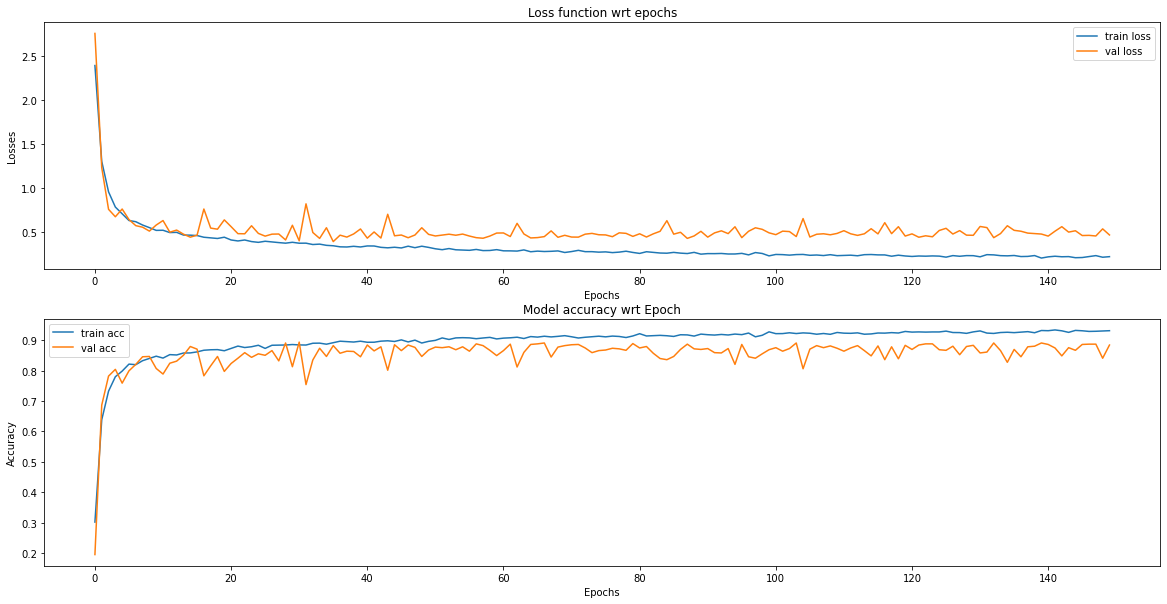

In [32]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

In [33]:
from keras.models import load_model
model = load_model('./result_model.h5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)

from sklearn.metrics import accuracy_score, classification_report
target_name = []
for i in sorted(info) :
    target_name.append(info[i])

In [34]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.8817307692307692
              precision    recall  f1-score   support

           2       0.92      0.95      0.93        58
           3       0.97      0.98      0.97        57
           4       0.93      0.96      0.95        54
           5       0.98      0.94      0.96        54
           6       0.97      0.92      0.94        62
           7       0.98      0.89      0.93        56
           8       0.91      0.95      0.93        55
           b       1.00      0.93      0.96        42
           c       0.81      0.89      0.85        47
           d       0.80      0.88      0.84        50
           e       0.95      0.86      0.90        42
           f       0.93      0.91      0.92        46
           g       0.96      0.98      0.97        50
           m       0.57      0.51      0.54        61
           n       0.69      0.75      0.72       102
           p       0.94      0.90      0.92        52
           w       0.89      0.85      0.87        

In [35]:
def get_demo (img_path) :
    
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    Xdemo = []
    for i in range(5) :
        Xdemo.append(img_to_array(Image.fromarray(image_list[i])))
    
    Xdemo = np.array(Xdemo)
    Xdemo/= 255.0
    
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    for res in ydemo :
        print(info[res])
    print(img_path[-9:])

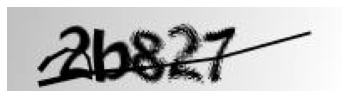

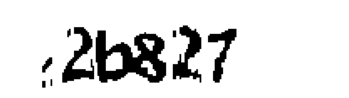

2
b
8
2
7
2b827.png


In [37]:
get_demo(r"C:\Users\naman\Downloads\archive (3)\samples\samples\2b827.png")